In [162]:
# import packages and libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import shapefile as shp
import re
import json
import requests
import warnings
import geopandas as gpd
import scipy.stats as stats
import string
from pygeocoder import Geocoder
from collections import defaultdict
from collections import OrderedDict
from IPython.display import HTML
from shapely.geometry import Point
from sklearn.cluster import Birch
from sklearn.exceptions import DataConversionWarning
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats
import gmaps
import gmaps.datasets
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'sqrt', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [163]:
# Load data from cleaned csv files - (Alt_Fuel_DW.ipynb contains the Data Wrangling code)
alt_fuels_df = pd.read_csv('open_fuels.csv',parse_dates = True, error_bad_lines=False,low_memory=False)

In [164]:
# Create Dataframe st_df to contain ID and OpenYear for grouping stations
st_df=alt_fuels_df[['ID','OpenDate']]

In [165]:
# Function to get year from dateAdded
def get_year(dt):
    return dt.year
def get_month(dt):
    return dt.month

In [166]:
st_df.head()

,ID,OpenDate
0,17,2010-12-01
1,42,1994-07-15
2,45,1996-12-15
3,64,1997-01-01
4,72,1996-12-15


In [167]:
ts_df = st_df.copy()
ts_df.OpenDate= pd.to_datetime(ts_df.OpenDate)
ts_df['Year'] = ts_df.OpenDate.map(get_year)
ts_df['Month'] = ts_df.OpenDate.map(get_month)

In [168]:
del ts_df['OpenDate']
st_cnt_year_month = ts_df.groupby(['Year','Month']).ID.agg('count').to_frame('Count').reset_index()

In [169]:
st_cnt_year_month = st_cnt_year_month[(st_cnt_year_month.Year>=2000) & (st_cnt_year_month.Year!=2019)]

In [170]:
st_cnt_year_month.tail()

,Year,Month,Count
306,2018,8,71
307,2018,9,136
308,2018,10,202
309,2018,11,1031
310,2018,12,161


In [171]:
st_cnt_year_month['Day']='01'
st_cnt_year_month['Year'] = st_cnt_year_month['Year'].astype(str)+'-'+st_cnt_year_month['Month'].astype(str)+\
'-'+st_cnt_year_month['Day'].astype(str)
st_cnt_year_month.head()

,Year,Month,Count,Day
91,2000-1-01,1,7,01
92,2000-3-01,3,19,01
93,2000-4-01,4,4,01
94,2000-6-01,6,3,01
95,2000-7-01,7,1,01


In [172]:
del st_cnt_year_month['Month']
del st_cnt_year_month['Day']
st_cnt_year_month.tail()

,Year,Count
306,2018-8-01,71
307,2018-9-01,136
308,2018-10-01,202
309,2018-11-01,1031
310,2018-12-01,161


In [173]:
st_cnt_year_month.Year= pd.to_datetime(st_cnt_year_month.Year)
st_cnt_year_month.set_index('Year', inplace=True)
st_cnt_year_month.index

DatetimeIndex(['2000-01-01', '2000-03-01', '2000-04-01', '2000-06-01',
               '2000-07-01', '2000-08-01', '2000-10-01', '2000-11-01',
               '2000-12-01', '2001-01-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='Year', length=220, freq=None)

In [174]:
series = st_cnt_year_month.Count

In [175]:
series.tail()

Year
2018-08-01      71
2018-09-01     136
2018-10-01     202
2018-11-01    1031
2018-12-01     161
Name: Count, dtype: int64

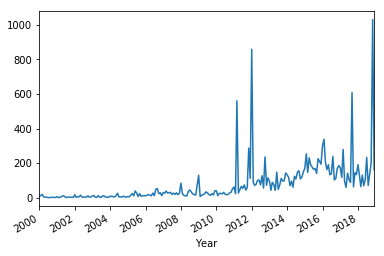

In [176]:
series.plot()

## Experimental Test Setup
We will split the alternative fuels dataset into two parts: a training and a test set.
66% of data will be taken for the training dataset and the remaining 34% of data will be used for the test set.

In [177]:
# Split into train and test sets
X = series.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

Models will be developed using the training dataset and will make predictions on the test dataset.

A rolling forecast scenario will be used, also called walk-forward model validation.

Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

## Persistence Forecast of Observed vs Predicted

RMSE: 177.989


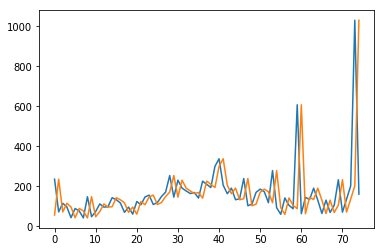

In [178]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

## LSTM

## Transform Time Series to Supervised Learning

The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.

We can then concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN (not a number) value will be used in this position. We will replace these NaN values with 0 values.

The code below defines a helper function to do this called timeseries_to_supervised(). It takes a NumPy array of the raw time series data and a lag or number of shifted series to create and use as inputs.

In [179]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

We can test this function with our loaded alternative fuel stations dataset and convert it into a supervised learning problem.

In [180]:
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

      0   0
0   0.0   7
1   7.0  19
2  19.0   4
3   4.0   3
4   3.0   1


## Transform Time Series to Stationary

The alternative fuel stations dataset is not stationary.

This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

Stationary data is easier to model and will very likely result in more skillful forecasts.

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

We can achieve this automatically using the diff() function in pandas. Alternatively, we can get finer grained control and write our own function to do this, which is preferred for its flexibility in this case.

Below is a function called difference() that calculates a differenced series. Note that the first observation in the series is skipped as there is no prior observation with which to calculate a differenced value.

In [181]:
from pandas import Series
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


## Transform Time Series to Scale

Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

To make the experiment fair, the scaling coefficients (min and max) values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

We can transform the dataset to the range [-1, 1] using the MinMaxScaler class. Like other scikit-learn transform classes, it requires data provided in a matrix format with rows and columns. Therefore, we must reshape our NumPy arrays before transforming.

In [182]:
from sklearn.preprocessing import MinMaxScaler
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


## LSTM Model Development

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

Samples: These are independent observations from the domain, typically rows of data.
Time steps: These are separate time steps of a given variable for a given observation.
Features: These are separate measures observed at the time of observation. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.

Given that the training dataset is defined as X inputs and y outputs, it must be reshaped into the Samples/TimeSteps/Features format.


In [183]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 

In [184]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [185]:
# split data into train and test-sets
train_size = int(len(supervised_values) * 0.66)
train, test = supervised_values[0:train_size], supervised_values[train_size:]

In [186]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

## LSTM Forecast

Once the LSTM model is fit to the training data, it can be used to make forecasts.
Again, we have some flexibility. We can decide to fit the model once on all of the training data, then predict each new time step one at a time from the test data (we’ll call this the fixed approach), or we can re-fit the model or update the model each time step of the test data as new observations from the test data are made available (we’ll call this the dynamic approach).

We will go with the fixed approach, although, we would expect the dynamic approach to result in better model skill.

To make a forecast, we can call the predict() function on the model. This requires a 3D NumPy array input as an argument. In this case, it will be an array of one value, the observation at the previous time step.

The predict() function returns an array of predictions, one for each input row provided. Because we are providing a single input, the output will be a 2D NumPy array with one value.

We can capture this behavior in a function named forecast() listed below. Given a fit model, a batch-size used when fitting the model, and a row from the test data, the function will separate out the input data from the test row, reshape it, and return the prediction as a single floating point value.

In [149]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

In [187]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 

array([[-0.66499794],
       [-0.5238522 ],
       [-0.3870498 ],
       [-0.36901653],
       [-0.37458622],
       [-0.38544762],
       [-0.39390552],
       [-0.38750553],
       [-0.39044964],
       [-0.40008712],
       [-0.38316298],
       [-0.38734365],
       [-0.41108716],
       [-0.39695585],
       [-0.37143087],
       [-0.38334155],
       [-0.39133143],
       [-0.38943517],
       [-0.38669175],
       [-0.42479306],
       [-0.3723203 ],
       [-0.3859241 ],
       [-0.38659394],
       [-0.41411585],
       [-0.3734839 ],
       [-0.38044524],
       [-0.38382924],
       [-0.40815157],
       [-0.38057685],
       [-0.38748556],
       [-0.40147197],
       [-0.40426123],
       [-0.3715431 ],
       [-0.3753507 ],
       [-0.40874517],
       [-0.3802904 ],
       [-0.37982666],
       [-0.40699673],
       [-0.39840895],
       [-0.3752674 ],
       [-0.38273084],
       [-0.38311678],
       [-0.40464878],
       [-0.39345407],
       [-0.3827418 ],
       [-0

Month=1, Predicted=230.258438, Expected=236.000000
Month=2, Predicted=-43.842336, Expected=72.000000
Month=3, Predicted=406.904286, Expected=115.000000
Month=4, Predicted=-38.776963, Expected=97.000000
Month=5, Predicted=251.918843, Expected=43.000000
Month=6, Predicted=-6.738522, Expected=89.000000
Month=7, Predicted=148.887641, Expected=77.000000
Month=8, Predicted=103.749141, Expected=42.000000
Month=9, Predicted=162.046639, Expected=148.000000
Month=10, Predicted=4.229213, Expected=48.000000
Month=11, Predicted=272.837750, Expected=74.000000
Month=12, Predicted=26.994933, Expected=112.000000
Month=13, Predicted=125.520749, Expected=96.000000
Month=14, Predicted=140.772610, Expected=98.000000
Month=15, Predicted=145.080240, Expected=143.000000
Month=16, Predicted=104.124634, Expected=133.000000
Month=17, Predicted=193.612378, Expected=117.000000
Month=18, Predicted=184.672978, Expected=70.000000
Month=19, Predicted=160.671953, Expected=96.000000
Month=20, Predicted=132.708645, Expec

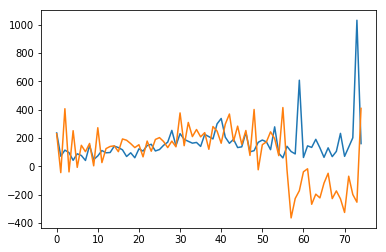

In [188]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rv = series.values
rvtestsize = int(len(rv) * 0.66)
rmse = sqrt(mean_squared_error(raw_values[rvtestsize:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[rvtestsize:])
pyplot.plot(predictions)
pyplot.show()

## Develop a Robust Result

A difficulty with neural networks is that they give different results with different starting conditions.

One approach might be to fix the random number seed used by Keras to ensure the results are reproducible. Another approach would be to control for the random initial conditions using a different experimental setup.

We can repeat the experiment from the previous section multiple times, then take the average RMSE as an indication of how well the configuration would be expected to perform on unseen data on average.

This is often called multiple repeats or multiple restarts.

We can wrap the model fitting and walk-forward validation in a loop of fixed number of repeats. Each iteration the RMSE of the run can be recorded. We can then summarize the distribution of RMSE scores.

## We will use 30 repeats as that is sufficient to provide a good distribution of RMSE scores.

In [190]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train_size = int(len(supervised_values) * 0.66)
train, test = supervised_values[0:train_size], supervised_values[train_size:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 30
error_scores = list()

rv = series.values
rvtestsize = int(len(rv) * 0.66)

In [ ]:
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[rvtestsize:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
 
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

1) Test RMSE: 210.827
2) Test RMSE: 177.944
3) Test RMSE: 154.478
4) Test RMSE: 173.732
5) Test RMSE: 198.704
6) Test RMSE: 234.263
7) Test RMSE: 221.272
8) Test RMSE: 229.307
9) Test RMSE: 175.612
10) Test RMSE: 192.698
11) Test RMSE: 175.661
12) Test RMSE: 130.317
13) Test RMSE: 204.678
14) Test RMSE: 142.863
15) Test RMSE: 210.013
16) Test RMSE: 155.257
17) Test RMSE: 195.996
18) Test RMSE: 183.120
19) Test RMSE: 150.319
